# Helper Script
---

In [135]:
!pip install nilearn --quiet

In [136]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

Here is a collection of Global Constants used in the code:

- N_SUBJECTS = Number of subjects included `int`
- N_PARCELS = The number of regions of interest `int`
- TR = Time resolution, in seconds `float`
- HEMIS = The parcels (region of interests) are matched across hemisphere with the same order `[list of strings]`
- N_RUNS = Number of times the experiment was performed on each subject `int`
- RUNS = Name tags for the runs `[list of strings]`
- EXPERIMENTS = Contains task names as keys and task conditions as value `dict of dict`

In [137]:
N_SUBJECTS = 100

N_PARCELS = 360

TR = 0.72  

HEMIS = ["Right", "Left"]

RUNS   = ['LR','RL']
N_RUNS = 2

EXPERIMENTS = {
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'SOCIAL'     : {'cond':['mental','rnd']}
}

In [138]:
HCP_DIR = r'/Users/rajdeep_ch/Documents/nma/project/hcp_task'

In [139]:
subjects = list(np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'), dtype='str'))

Here is the list of 100 subject ids

In [140]:
            subjects

['100307',
 '100408',
 '101915',
 '102816',
 '103414',
 '103515',
 '103818',
 '105115',
 '105216',
 '106016',
 '106319',
 '110411',
 '111009',
 '111312',
 '111514',
 '111716',
 '113215',
 '113619',
 '114924',
 '115320',
 '117122',
 '117324',
 '118730',
 '118932',
 '119833',
 '120111',
 '120212',
 '122317',
 '123117',
 '124422',
 '125525',
 '126325',
 '127933',
 '128632',
 '129028',
 '130013',
 '130316',
 '130922',
 '131924',
 '133625',
 '133827',
 '133928',
 '134324',
 '135932',
 '136833',
 '137128',
 '138231',
 '138534',
 '139637',
 '140824',
 '142828',
 '143325',
 '148032',
 '148335',
 '149337',
 '149539',
 '150524',
 '151223',
 '151526',
 '151627',
 '153025',
 '153429',
 '154431',
 '156233',
 '156637',
 '157336',
 '158035',
 '158540',
 '159239',
 '159340',
 '160123',
 '161731',
 '162329',
 '162733',
 '163129',
 '163432',
 '167743',
 '172332',
 '175439',
 '176542',
 '178950',
 '182739',
 '185139',
 '188347',
 '189450',
 '190031',
 '192439',
 '192540',
 '193239',
 '194140',
 '196144',

In [141]:
task_list = list(EXPERIMENTS.keys())

### Helper 1 - Loading Time Series for single subject



In [142]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  RUNS = {0: 'LR', 1: 'RL'}
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


### Helper 2 - Loading evs 

In [143]:
def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []

  RUNS = {0: 'LR', 1: 'RL'}

  TR = 0.72
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['mental','rnd']}
  }

  for cond in EXPERIMENTS[experiment]['cond']:

    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))

    #print(ev)
    
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    #print(start)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"]/TR).astype(int)
    #print("Start: {} | Duration: {}".format(start,duration))

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  # frames_list is returning a list of time duration
  # ev is returning the explanatory variables
  return frames_list

### Helper 3 - Average Frames

### CURRENTLY NOT WORKING

In [144]:
def average_frames(timeseries_data, evs_data, experiment_name, task_cond):
    """ 
    The function takes in the brain activity measures and behavioural measures for a particular subject in a given task condition.

    The function returns the brain activity average across all trail points.
    The corresponding average contains the time-average brain activity across all ROIs 

    Input:
        timeseries_data (ndarray): Contains the timeseries data for a single subject in a given experiment
        evs_data (ndarray): Contains the evs data for the single subject
        experiment_name (str): Name of the experiment (EMOTION/SOCIAL)
        task_condition (str): string name for task condition (fear/neut)

    Returns:
        average_values (ndarray): time-average activation across all ROIs
            shape = (ROIs,1)

    """

    idx = EXPERIMENTS[experiment_name]['cond'].index(task_cond)
    print('IDX: {}'.format(idx))

    print('Here is evs[idx][-1][-1]: {}'.format(evs_data[idx][-1][-1]),end="\n")
    print("Length of timepoints: {}".format(timeseries_data.shape[2]))

    #if evs_data[idx][-1][-1] > timeseries_data.shape[2]:
        #print("Conditional works!")
        #average_values = np.mean(np.concatenate([np.mean(timeseries_data[:,evs_data[idx][i]],axis=1,keepdims=True) for i in range(len(evs_data[idx])-1)], axis = -1), axis = 1)

    #else:
        #print("No need for conditional to work")
        #average_values = np.mean(np.concatenate([np.mean(timeseries_data[:,evs_data[idx][i]],axis=1,keepdims=True) for i in range(len(evs_data[idx]))], axis = -1), axis = 1)

    #return average_values

In [145]:
average_frames(emotion_timeseries[0],emotion_evs[0],'EMOTION','neut')

IDX: 1
Here is evs[idx][-1][-1]: 156


IndexError: tuple index out of range

---

### Function 1 - `load_all_timeseries()`

Loads the timeseries for all subjects

In [146]:
def load_all_timeseries(subject_list, experiment_name, run_num):
    """ 
    Reads the timeseries data of all subjects contained in the subject list for a given experiment
    and given run.

    Inputs:
        subject_list (list): List containing subject ids
        experiment_name (str): Name of task under consideration
        run_num (int): Number of run task

    Return:
        data_array (ndarray): timeseries data of all subjects

        shape of data returned : (100,360,timepoints)
    """

    data_list = []

    for sub_id in subject_list:
        
        sub_data = load_single_timeseries(sub_id,experiment_name,run_num)
        data_list.append(sub_data)

    data_array = np.array(data_list)
    return data_array

loading task data for `emotion`, `social`, `gambling` data for all subjects in the first run

In [147]:
# currently taking data for run 1 (LR)

emotion_timeseries = load_all_timeseries(subjects,'EMOTION',0)
social_timeseries = load_all_timeseries(subjects,'SOCIAL',0)
gambling_timeseries = load_all_timeseries(subjects,'GAMBLING',0)

### Function 2 - `load_all_evs()`

Loads the evs data for all subjects across all task conditions.

In [148]:
def load_all_evs(subject_list,experiment_name,run_num):
    """ 
    Reads the evs data for all subjects in subject list across all task conditions

    Inputs:
        subject_list (list): List containing subject ids
        experiment_name (str): Name of task under consideration
        run_num (int): Number of run task

    Returns:
        data_array (ndarray): explanatory variables (ev) for all subjects

    """

    data_list = []

    for sub_id in subject_list:

        sub_evs = load_evs(sub_id,experiment_name,run_num)
        data_list.append(sub_evs)

    data_array = np.array(data_list)
    return data_array
    #return data_list

In [149]:
# load_all_evs() returns a list of explanatory variables data

emotion_evs = load_all_evs(subjects,'EMOTION',0)
#social_evs = load_all_evs(subjects,'SOCIAL',0)
gambling_evs = load_all_evs(subjects,'GAMBLING',0)


In [150]:
emotion_evs = load_all_evs(subjects,'EMOTION',0)

In [151]:
emotion_evs.shape

(100, 2, 3, 25)

### Function 3 -  `all_average_frames()`

The function loads in the average timeseries for all subjects for a given experiement's task condition.

In [152]:
def all_average_frames(subject_list, timeseries_data, evs_data, experiment_name, task_cond):
    """ 
    The function takes in the brain activity measures and behavioural measures for all subjects in a given task condition.

    The function returns the brain activity average across all trail points.
    The corresponding average contains the time-average brain activity across all ROIs 

    Input:
        timeseries_data (ndarray): Contains the timeseries data for all subjects in a given experiment
        evs_data (ndarray): Contains the evs data for all subject
        experiment_name (str): Name of the experiment (EMOTION/SOCIAL)
        task_condition (str): string name for task condition (fear/neut)

    Returns:
        average_values (ndarray): time-average activation across all ROIs
            shape = (number of subjects, ROIs , 1)
    """

    data_array = np.zeros((len(subject_list),360))

    for sub_num in range(len(subject_list)):

        sub_average = average_frames(timeseries_data[sub_num], evs_data[sub_num], experiment_name, task_cond)
        data_array[sub_num] = sub_average
        #np.append(data_array,sub_average)

    return data_array



In [153]:
print("Shape of Emotion EVS: {}".format(np.array(emotion_evs).shape))
print("Shape of Social EVS: {}".format(np.array(social_evs).shape))
print("Shape of Gambling EVS: {}".format(np.array(gambling_evs).shape))

Shape of Emotion EVS: (100, 2, 3, 25)
Shape of Social EVS: (100, 2)
Shape of Gambling EVS: (100, 2, 2, 39)



**bug 1** - adding conditional for load_evs() to ensure the duration_times line up timeseries_timepoints

currently `average_frames()` does not work. 
- remove the buggy conditional

---

In [154]:
def average_frames(timeseries_data, evs_data, experiment_name, task_cond):
    """ 
    The function takes in the timeseries data and evs data for a particular subject and a given task condition
    for a particular experiment
    """

    idx = EXPERIMENTS[experiment_name]['cond'].index(task_cond)
    #print('IDX: {}'.format(idx))

    #print('Here is evs[idx][-1][-1]: {}'.format(evs_data[idx][-1][-1]),end="\n")
    #print("Length of timepoints: {}".format(timeseries_data.shape[2]))

    #if evs_data[idx][-1][-1] > timeseries_data.shape[2]:
        #print("Conditional works!")
        #average_values = np.mean(np.concatenate([np.mean(timeseries_data[:,evs_data[idx][i]],axis=1,keepdims=True) for i in range(len(evs_data[idx])-1)], axis = -1), axis = 1)

    #else:
    #print("No need for conditional to work")
    average_values = np.mean(np.concatenate([np.mean(timeseries_data[:,evs_data[idx][i]],axis=1,keepdims=True) for i in range(len(evs_data[idx]))], axis = -1), axis = 1)

    return average_values

---

In [155]:
def load_all_task_score(subject_list, experiment_name, run_num):
  """
  Load task performance statistics for one task experiment.

  Args:
    subject_list (str): subject IDs to load
    experiment_name (str) : Name of experiment
    run_num (int): 0 or 1

  Returns
    task_scores (list of lists): A list of task performance scores for all subjects in a particular run

  """
  task_scores = []

  RUNS = {0: 'LR', 1: 'RL'}

  #TR = 0.72
  task_key = f'tfMRI_{experiment_name}_{RUNS[run_num]}'
  EXPERIMENTS = {
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'SOCIAL'     : {'cond':['mental','rnd']}
  }
      
  for sub_id in subject_list:

    #ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    task_file_loc = os.path.join(HCP_DIR,'subjects/{}/{}/{}/EVs/Stats.txt'.format(sub_id,experiment_name,task_key))
    #ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    #ev = dict(zip(["onset", "duration", "amplitude"], ev_array))

    sub_task_score = get_task_data(task_file_loc)
    task_scores.append(sub_task_score)

  return task_scores

In [156]:
def get_task_data(taskfile_loc):
    """
    Loads the task data from file location and returns a tuple containing column name
    and data

    Input:
        taskfile (TextIOWrapper) - file location for performance statistics

    Return:
        task_score = (column name, task score)
    """
    subject_all_score = []

    with open(taskfile_loc,'r') as taskfile:

        for line in taskfile:

            data = line.strip().split(':')

            string_data = data[0]
            numeric_data = float(data[1])
            output_data = ((string_data,numeric_data))
            subject_all_score.append(output_data)

        taskfile.close()

    return subject_all_score

In [157]:
emotion_ts = load_all_task(subjects[:25],'EMOTION',0)

NameError: name 'load_all_task' is not defined

In [158]:
emotion_ts

[[('Face Accuracy', 1.0),
  ('Shape Accuracy', 0.944444444444),
  ('Median Face RT', 623.8),
  ('Median Shape RT', 660.588235294)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 670.866666667),
  ('Median Shape RT', 711.944444444)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 0.944444444444),
  ('Median Face RT', 834.533333333),
  ('Median Shape RT', 864.647058824)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 661.2),
  ('Median Shape RT', 711.111111111)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 856.133333333),
  ('Median Shape RT', 784.722222222)],
 [('Face Accuracy', 0.933333333333),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 759.285714286),
  ('Median Shape RT', 771.722222222)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 797.066666667),
  ('Median Shape RT', 917.555555556)],
 [('Face Accuracy', 1.0),
  ('Shape Accuracy', 1.0),
  ('Median Face RT', 717.0)

In [159]:
social_ts = load_all_task(subjects[:5],'SOCIAL',0)

NameError: name 'load_all_task' is not defined

In [160]:
social_ts[0]

[('Mean RT Mental', 479.0),
 ('Mean RT Random', 575.0),
 ('ACC Mental', 1.0),
 ('ACC Random', 1.0),
 ('Percent Mental', 0.6),
 ('Percent Random', 0.4),
 ('Percent Unsure', 0.0),
 ('Percent No Response', 0.0)]

In [161]:
task_score_col = ['Face Accuracy','Shape Accuracy', 'Median Face RT','Median Shape RT']

In [162]:
df1 = pd.DataFrame(columns=task_score_col)

In [163]:
df1.head()

,Face Accuracy,Shape Accuracy,Median Face RT,Median Shape RT


In [164]:
HCP_DIR

'/Users/rajdeep_ch/Documents/nma/project/hcp_task'

In [165]:
taskfile_loc = os.path.join(HCP_DIR,'subjects/159340/EMOTION/tfMRI_EMOTION_LR/EVs/Stats.txt')

In [166]:
taskfile_loc

'/Users/rajdeep_ch/Documents/nma/project/hcp_task/subjects/159340/EMOTION/tfMRI_EMOTION_LR/EVs/Stats.txt'

In [167]:
taskfile = open(taskfile_loc,"r")
#print(taskfile.read())
type(taskfile)

_io.TextIOWrapper

In [169]:
test_list = []

with open(taskfile_loc,'r') as taskfile:

    for line in taskfile:

        data = line.strip().split(':')

        print(data)
        string_data = data[0]
        numbers = float(data[1])
        print(float(data[1]))
        print(numbers)
        test_list.append((string_data,numbers))

['Face Accuracy', ' 1.0']
1.0
1.0
['Shape Accuracy', ' 1.0']
1.0
1.0
['Median Face RT', ' 890.066666667']
890.066666667
890.066666667
['Median Shape RT', ' 1022.22222222']
1022.22222222
1022.22222222


In [ ]:
df = pd.DataFrame(np.array(test_list).T)

In [ ]:
df.head()

,0,1,2,3
0,Face Accuracy,Shape Accuracy,Median Face RT,Median Shape RT
1,1.0,1.0,890.066666667,1022.22222222


In [ ]:
df.columns.name = None 

In [ ]:
df.columns = list(df.iloc[0,:])

In [ ]:
df.drop(0)

,Face Accuracy,Shape Accuracy,Median Face RT,Median Shape RT
1,1.0,1.0,890.066666667,1022.22222222



## Working with regions file

---

In [ ]:
def get_task_contrast(subject_list,experiment_name,run_num):

    # load in the timeseries for the subject
    # load in the evs for the subject
    # use the average frames function to get the needed data

    task_timeseries = load_all_timeseries(subject_list,experiment_name,run_num)
    task_evs = load_all_evs(subject_list,experiment_name,run_num)
    task_average = all_average_frames(subject_list,experiment_name,run_num)

    

    

In [170]:
regions_loc = os.path.join(HCP_DIR,'regions.npy')

In [171]:
regions = np.load(regions_loc).T

In [ ]:
region_info = dict(Name=list(regions[0]), Map= list(regions[1]), Hemi = ['Right'] * int(N_PARCELS/2) + ['Left'] * int(N_PARCELS/2))

In [ ]:
region_df = pd.DataFrame(region_info)

In [ ]:
region_df.head()

,Name,Map,Hemi
0,R_V1,Visual1,Right
1,R_MST,Visual2,Right
2,R_V6,Visual2,Right
3,R_V2,Visual2,Right
4,R_V3,Visual2,Right


In [ ]:
#SOCIAL

my_exp = 'SOCIAL'
#calculate group contrast SOCIAL
group_contrast_social = 0

# for a particular subject in the list of subjects
for s in subjects:
  
  # for a particular run of the selected subject
  # the loop collects timeseries and evs data for all runs
  # it calculates the constrast across the task conditions in each run and adds it to the group's data
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    mental_activity = average_frames(data, evs, my_exp, 'mental')
    rnd_activity = average_frames(data, evs, my_exp, 'rnd')

    contrast = mental_activity - rnd_activity
    group_contrast_social += contrast

group_contrast_social /= (len(subjects)*2)  # remember: 2 sessions per subject



#Plot contrast bar graph SOCIAL
df = pd.DataFrame({'contrast' : group_contrast_social,
                   'network' : region_info['Map'],
                   'hemi' : region_info['Hemi']
                   })
# we will plot the fear foot minus neutral foot contrast so we only need one plot
#plt.figure()
#sns.barplot(y='network', x='contrast', data=df, hue='hemi')
#plt.title('group contrast of mental vs random')
#plt.show()

No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need for conditional to work
No need 

In [ ]:
short_df = df.iloc[:25,0:2]

In [ ]:
short_df

,contrast,network
0,0.362457,Visual1
1,6.231128,Visual2
2,-9.718446,Visual2
3,-10.336252,Visual2
4,5.514508,Visual2
5,10.860714,Visual2
6,10.315644,Visual2
7,-4.458975,Somatomotor
8,-1.319525,Somatomotor
9,3.766011,Cingulo-Oper


In [ ]:
gambling_average1[0][0] - gambling_average2[0][0]

8.964454038151064

## Creating the task data and personality dataset

---

In [172]:
HCP_DIR

'/Users/rajdeep_ch/Documents/nma/project/hcp_task'

In [173]:
personlity_file = r'/Users/rajdeep_ch/Documents/nma/project/personality_data.csv'

In [174]:
personality_df = pd.read_csv(personlity_file)

In [175]:
personality_df = personality_df.iloc[:,0:6]

In [179]:
emotion_ts = load_all_task_score(subjects[:5],'EMOTION',0)

In [180]:
social_ts = load_all_task_score(subjects,'SOCIAL',0)

In [181]:
gambling_ts = load_all_task_score(subjects,'GAMBLING',0)

In [183]:
emotion_ts = load_all_task_score(subjects,'EMOTION',0)
emotion_face_score = np.zeros(len(emotion_ts))
emotion_shape_score = np.zeros(len(emotion_ts))

# testing for accuracy == 0
emotion_acc_val1 = np.zeros(len(emotion_ts))
emotion_acc_val2 = np.zeros(len(emotion_ts))

In [184]:
# loop running over all participants

for i in range(len(emotion_ts)):

    sub_task_vals = emotion_ts[i]
    #print(sub_task_vals[0],sub_task_vals[2])
    #print(sub_task_vals[1],sub_task_vals[3][1])
    face_acc, face_time = sub_task_vals[0][1], sub_task_vals[2][1]

    # test
    emotion_acc_val1[i] = face_acc

    shape_acc, shape_time = sub_task_vals[1][1], sub_task_vals[3][1]

    # test
    emotion_acc_val2[i] = shape_acc
    #print("Score for shape: {}".format(shape_time,shape_acc),end="\n")
    #print("Score for face: {}".format(face_time / face_acc))
    
    #emotion_face_score[i] =  (face_time / face_acc) / 100
     # (100 / 100) does not produce needed result
     # need to convert the value to percentage

     # use multi-nomial LR
    #emotion_shape_score[i] = (shape_time/ shape_acc) / 100

In [186]:
social_ts = load_all_task_score(subjects,'SOCIAL',0)
social_mental_score = np.zeros(len(social_ts))
social_random_score = np.zeros(len(social_ts))

# test arrays for checking social's accuracy == 0 ?
social_acc_val1 = np.zeros(len(social_ts))
social_acc_val2 = np.zeros(len(social_ts))

In [187]:
#dict_check = {}
subject_id_list_to_remove = []

for k in range(len(social_ts)):

    #if social_ts[k][3][1] not in dict_check:
        #dict_check[social_ts[k][3][1]] = 1
    #else:
       #dict_check[social_ts[k][3][1]] += 1
    #print(social_ts[k][3])

    if (social_ts[k][3][1]) == 0.0:
        subject_id_list_to_remove.append(subjects[k])
        

In [188]:
subject_id_list_to_remove

['133827', '192439']

In [190]:
social_ts[0]

[('Mean RT Mental', 479.0),
 ('Mean RT Random', 575.0),
 ('ACC Mental', 1.0),
 ('ACC Random', 1.0),
 ('Percent Mental', 0.6),
 ('Percent Random', 0.4),
 ('Percent Unsure', 0.0),
 ('Percent No Response', 0.0)]

In [191]:
for i in range(len(social_ts)):

    sub_social_score = social_ts[i]
    #print(sub_social_score)

    # mental reaction time; mental accuracy
    #print(sub_social_score[0],sub_social_score[2])

    # random reaction time; random accracy
    #print(sub_social_score[1],sub_social_score[3],end="\n")

    mental_rt, mental_acc = sub_social_score[0][1], sub_social_score[2][1]

    # test for mental_acc
    social_acc_val1[i] = mental_acc

    random_rt, random_acc = sub_social_score[1][1], sub_social_score[3][1]

    # test for random_acc
    social_acc_val2[i] = random_acc

    # zero division error since mental_acc == 0
    
    social_mental_score[i] = mental_rt / mental_acc 
    #social_random_score[i] = random_rt / random_acc

    #print('MENTAL: {}'.format(mental_rt / mental_acc))
    #print("RANDOM: {}".format(random_rt / random_acc),end="\n\n")


In [192]:
social_acc_val2

array([1. , 1. , 1. , 1. , 1. , 0.5, 0.5, 0.5, 1. , 1. , 0.5, 1. , 1. ,
       0.5, 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 1. ,
       1. , 1. , 1. , 0.5, 0.5, 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 0. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 0.5,
       1. , 0.5, 1. , 0.5, 0.5, 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 0.5,
       1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 1. ,
       1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 0. , 1. , 1. , 0.5, 0.5,
       1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 0.5])

HERE

In [193]:
gambling_ts = load_all_task(subjects,'GAMBLING',0)

gambling_task_score = np.zeros(len(gambling_ts))

# array to test accuracy scores
gambling_acc = np.zeros(len(gambling_ts))

NameError: name 'load_all_task' is not defined

In [194]:
for i in range(len(gambling_ts)):

    sub_gambling_score = gambling_ts[i]
    #print(sub_gambling_score)

    #print(sub_gambling_score[0], sub_gambling_score[2])

    gamb_time = sub_gambling_score[0][1]

    gamb_acc = sub_gambling_score[2][1]

    gambling_acc[i] = gamb_acc

    #print(gamb_acc)

In [ ]:
np.any(gambling_acc == 0)

False

In [ ]:
corr_df = pd.DataFrame(emotion_average)

In [ ]:
corr_mat = corr_df.corr()

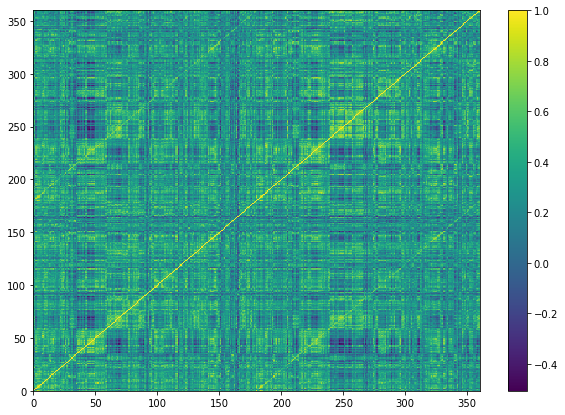

In [ ]:
plt.figure(figsize=(10,7))
plt.pcolor(corr_mat)
plt.colorbar()

## Classifying the personality trait data

---

In [195]:
personality_df.head()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,100307,37,24,35,15,37
1,100408,33,29,34,15,33
2,101915,35,30,45,8,31
3,102816,36,27,32,10,31
4,103414,27,30,31,20,34


In [196]:
test_personality = pd.DataFrame(personality_df)

In [197]:
test_personality.tail()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
95,199655,24,29,33,15,28
96,200614,42,22,43,9,38
97,201111,36,35,42,31,23
98,201414,41,37,37,8,38
99,205119,40,30,37,11,33


In [198]:
for p in range(3):

    aSr = test_personality.iloc[p,1:]
    aSr

In [199]:
class_personality = pd.DataFrame()


In [200]:
class_personality.head()

""


script for loading the personality data and classifying the personality trait scores

- score between 0 to 15 - 0 (LOW)
- score between 16 to 30 - 1 (AVG)
- else (score higher than 30) - 2 (HIGH)

In [201]:
label_list = []

for row_num in range(test_personality.shape[0]):

    sub_data = test_personality.iloc[row_num,:]

    for value in sub_data[1:]:

        if value in range(0,16):
            label_list.append(0)

        elif value in range(16,31):
            label_list.append(1)

        else:
            label_list.append(2)
    
    label_list.insert(0,sub_data[0])
    class_personality = pd.concat([class_personality,pd.Series(label_list)],axis=1)
    label_list = []



In [202]:
class_personality.head()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,100307,100408,101915,102816,103414,103515,103818,105115,105216,106016,...,196144,196750,197550,198451,199150,199655,200614,201111,201414,205119
1,2,2,2,2,1,1,2,2,1,2,...,2,2,2,1,2,1,2,2,2,2
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,1,1,1,2,2,1
3,2,2,2,2,2,2,2,1,1,2,...,2,2,2,2,2,2,2,2,2,2
4,0,0,0,0,1,1,1,1,1,0,...,1,1,2,1,0,0,0,2,0,0


In [203]:
class_personality = class_personality.transpose()

In [204]:
class_personality.columns = personality_df.columns

In [205]:
class_personality.head()

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,100307,2,1,2,0,2
0,100408,2,1,2,0,2
0,101915,2,1,2,0,2
0,102816,2,1,2,0,2
0,103414,1,1,2,1,2


In [206]:
class_personality.iloc[:25,:]

,Subject,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,100307,2,1,2,0,2
0,100408,2,1,2,0,2
0,101915,2,1,2,0,2
0,102816,2,1,2,0,2
0,103414,1,1,2,1,2
0,103515,1,1,2,1,1
0,103818,2,1,2,1,1
0,105115,2,1,1,1,1
0,105216,1,1,1,1,1
0,106016,2,1,2,0,1


In [ ]:
class_personality.to_csv(r'/Users/rajdeep_ch/Documents/nma/project/personality_data_classified.csv',index=False)

In [ ]:
list(np.where(class_personality["Subject"] == '133827'))

[array([], dtype=int64)]

In [ ]:
testing = list(class_personality['Subject'])

In [ ]:
testing.index(133827)

40

In [ ]:
testing.index(192439)

86

In [ ]:
class_personality.iloc[40,:]

Subject     133827
NEOFAC_A         2
NEOFAC_O         1
NEOFAC_C         2
NEOFAC_N         0
NEOFAC_E         1
Name: 0, dtype: int64

In [ ]:
class_personality.iloc[86,:]

Subject     192439
NEOFAC_A         2
NEOFAC_O         1
NEOFAC_C         2
NEOFAC_N         2
NEOFAC_E         2
Name: 0, dtype: int64

In [ ]:
class_personality = class_personality.drop(40)

KeyError: '[40] not found in axis'

---

In [ ]:
help(load_all_timeseries)

Help on function load_all_timeseries in module __main__:

load_all_timeseries(subject_list, experiment_name, run_num)
    Reads the timeseries data of all subjects contained in the subject list for a given experiment
    and given run.
    
    Inputs:
        subject_list (list): List containing subject ids
        experiment_name (str): Name of task under consideration
        run_num (int): Number of run task
    
    Return:
        data_array (ndarray): timeseries data of all subjects
    
        shape of data returned : (100,360,timepoints)



In [ ]:
help(load_all_evs)

Help on function load_all_evs in module __main__:

load_all_evs(subject_list, experiment_name, run_num)
    Reads the evs data for all subjects in subject list across all task conditions
    
    Inputs:
        subject_list (list): List containing subject ids
        experiment_name (str): Name of task under consideration
        run_num (int): Number of run task
    
    Returns:
        data_array (ndarray): explanatory variables (ev) for all subjects



In [ ]:
help(all_average_frames)

Help on function all_average_frames in module __main__:

all_average_frames(subject_list, timeseries_data, evs_data, experiment_name, task_cond)
    The function takes in the brain activity measures and behavioural measures for all subjects in a given task condition.
    
    The function returns the brain activity average across all trail points.
    The corresponding average contains the time-average brain activity across all ROIs 
    
    Input:
        timeseries_data (ndarray): Contains the timeseries data for all subjects in a given experiment
        evs_data (ndarray): Contains the evs data for all subject
        experiment_name (str): Name of the experiment (EMOTION/SOCIAL)
        task_condition (str): string name for task condition (fear/neut)
    
    Returns:
        average_values (ndarray): time-average activation across all ROIs
            shape = (number of subjects, ROIs , 1)



In [ ]:
help(load_all_task_score)

Help on function load_all_task_score in module __main__:

load_all_task_score(subject_list, experiment_name, run_num)
    Load task performance statistics for one task experiment.
    
    Args:
      subject_list (str): subject IDs to load
      experiment_name (str) : Name of experiment
      run_num (int): 0 or 1
    
    Returns
      task_scores (list of lists): A list of task performance scores for all subjects in a particular run



In [207]:
emotion_timeseries = load_all_timeseries(subjects,'EMOTION',0)
emotion_evs = load_all_evs(subjects,'EMOTION',0)
emotion_average = all_average_frames(emotion_timeseries,emotion_evs,'EMOTION','f')

TypeError: all_average_frames() missing 1 required positional argument: 'task_cond'

In [208]:
emotion_ts = load_all_task_score(subjects,'EMOTION',0)

emotion_face_score = np.zeros(len(emotion_ts))
emotion_shape_score = np.zeros(len(emotion_ts))

avoid_subjects = ['133827', '192439']

In [209]:
# loop running over all participants

for i in range(len(emotion_ts)):

    sub_task_vals = emotion_ts[i]
    #print(sub_task_vals[0][1],sub_task_vals[2][1])
    #print(sub_task_vals[1][1],sub_task_vals[3][1])

    if subjects[i] not in avoid_subjects:

        face_acc, face_time = sub_task_vals[0][1], sub_task_vals[2][1]
        ies_face = face_time / (100 * face_acc)
        emotion_face_score[i] = ies_face

        shape_acc, shape_time = sub_task_vals[1][1], sub_task_vals[3][1]
        ies_shape = shape_time / (100 * shape_acc)
        emotion_shape_score[i] = ies_shape

    else:
        emotion_face_score[i] = -1
        emotion_shape_score[i] = -1 



    # test
    ## emotion_acc_val1[i] = face_acc

    ###shape_acc, shape_time = sub_task_vals[1][1], sub_task_vals[3][1]

    # test
    ## emotion_acc_val2[i] = shape_acc
    #print("Score for shape: {}".format(shape_time,shape_acc),end="\n")
    #print("Score for face: {}".format(face_time / face_acc))
    
    #emotion_face_score[i] =  (face_time / face_acc) / 100
     # (100 / 100) does not produce needed result
     # need to convert the value to percentage

     # use multi-nomial LR
    #emotion_shape_score[i] = (shape_time/ shape_acc) / 100

emotion IES for condition 1 - emotion_face_score

emotion IES for condition 2 - emotion_shape_score

In [210]:
social_ts = load_all_task_score(subjects,'SOCIAL',0)
social_mental_score = np.zeros(len(social_ts))
social_random_score = np.zeros(len(social_ts))

In [211]:
for i in range(len(social_ts[:])):

    sub_social_score = social_ts[i]
    #print(sub_social_score)

    # mental reaction time; mental accuracy
    #print(sub_social_score[0],sub_social_score[2])

    # random reaction time; random accracy
    #print(sub_social_score[1],sub_social_score[3],end="\n")

    if subjects[i] not in avoid_subjects:

        mental_rt, mental_acc = sub_social_score[0][1], sub_social_score[2][1]
        ies_mental = mental_rt / (100 * mental_acc)
        print("MENTAL RT: {} | MENTAL ACC : {}| MENTAL IES: {}".format(mental_rt,mental_acc,ies_mental))
        social_mental_score[i] = ies_mental
        print(social_mental_score[i])

        random_rt, random_acc = sub_social_score[1][1], sub_social_score[3][1]
        ies_random = random_rt / (100 * random_acc)
        social_random_score[i] = ies_random

    else:
        social_mental_score[i] = -1
        social_random_score[i] = -1
    # test for mental_acc
    #social_acc_val1[i] = mental_acc

    #random_rt, random_acc = sub_social_score[1][1], sub_social_score[3][1]

    # test for random_acc
    #social_acc_val2[i] = random_acc

    # zero division error since mental_acc == 0
    
    #social_mental_score[i] = mental_rt / mental_acc 
    #social_random_score[i] = random_rt / random_acc

    #print('MENTAL: {}'.format(mental_rt / mental_acc))
    #print("RANDOM: {}".format(random_rt / random_acc),end="\n\n")


MENTAL RT: 479.0 | MENTAL ACC : 1.0| MENTAL IES: 4.79
4.79
MENTAL RT: 1059.33333333 | MENTAL ACC : 1.0| MENTAL IES: 10.5933333333
10.5933333333
MENTAL RT: 1193.0 | MENTAL ACC : 1.0| MENTAL IES: 11.93
11.93
MENTAL RT: 1189.0 | MENTAL ACC : 1.0| MENTAL IES: 11.89
11.89
MENTAL RT: 738.666666667 | MENTAL ACC : 1.0| MENTAL IES: 7.386666666669999
7.386666666669999
MENTAL RT: 720.5 | MENTAL ACC : 0.666666666667| MENTAL IES: 10.807499999994597
10.807499999994597
MENTAL RT: 914.0 | MENTAL ACC : 1.0| MENTAL IES: 9.14
9.14
MENTAL RT: 914.0 | MENTAL ACC : 1.0| MENTAL IES: 9.14
9.14
MENTAL RT: 712.666666667 | MENTAL ACC : 1.0| MENTAL IES: 7.126666666669999
7.126666666669999
MENTAL RT: 680.333333333 | MENTAL ACC : 1.0| MENTAL IES: 6.80333333333
6.80333333333
MENTAL RT: 1181.66666667 | MENTAL ACC : 1.0| MENTAL IES: 11.8166666667
11.8166666667
MENTAL RT: 862.0 | MENTAL ACC : 1.0| MENTAL IES: 8.62
8.62
MENTAL RT: 1148.66666667 | MENTAL ACC : 1.0| MENTAL IES: 11.4866666667
11.4866666667
MENTAL RT: 524.6

In [212]:
social_mental_score

array([ 4.79      , 10.59333333, 11.93      , 11.89      ,  7.38666667,
       10.8075    ,  9.14      ,  9.14      ,  7.12666667,  6.80333333,
       11.81666667,  8.62      , 11.48666667,  5.24666667,  7.76666667,
        6.83      , 23.91      ,  9.39666667, 10.575     ,  5.91      ,
        8.27333333,  7.07      ,  8.56666667,  6.58666667,  8.65666667,
        9.84      ,  8.49333333, 10.58      ,  4.57666667,  8.33      ,
       37.65      ,  8.06      ,  7.67666667,  7.62333333,  8.56333333,
        7.89666667,  7.07333333,  6.05      ,  6.47      ,  7.97666667,
       -1.        ,  9.88333333,  9.91      ,  8.1975    ,  9.66333333,
        5.78666667, 10.9575    ,  5.57333333,  7.42      ,  7.02666667,
        9.12      , 10.22      ,  7.44333333, 10.86      , 12.04333333,
       21.41666667, 14.58333333,  7.59333333, 10.31333333,  5.49666667,
        6.47      ,  9.26333333,  8.41333333, 11.3475    , 13.67666667,
        5.55333333,  5.73333333, 10.01666667,  7.06666667,  5.43

In [213]:
gambling_ts = load_all_task_score(subjects,'GAMBLING',0)

gambling_task_score = np.zeros(len(gambling_ts))

# array to test accuracy scores
gambling_acc = np.zeros(len(gambling_ts))

In [214]:
for i in range(len(gambling_ts)):

    sub_gambling_score = gambling_ts[i]
    #print(sub_gambling_score)

    #print(sub_gambling_score[0], sub_gambling_score[2])

    if subjects[i] not in avoid_subjects:

        gamb_time = sub_gambling_score[0][1]
        gamb_acc = sub_gambling_score[2][1]
        ies_gamb = gamb_time / (100 * gamb_acc)
        gambling_task_score[i] = ies_gamb

    else:
        gambling_task_score[i] = -1

In [215]:
gambling_task_score

array([ 3.6090625 ,  4.811875  ,  5.093125  ,  4.874375  ,  4.7040625 ,
        3.329375  ,  3.678125  ,  3.555     ,  3.0796875 ,  3.3903125 ,
        8.1771875 ,  3.0190625 ,  3.63625   ,  3.7440625 ,  2.980625  ,
        5.8440625 ,  3.91225806,  4.42006243,  3.9453125 ,  6.2940625 ,
        5.06305931,  5.6909375 ,  3.14      ,  5.16795005,  5.880625  ,
        6.27080125,  5.4365625 ,  5.219375  ,  2.9871875 ,  4.95983351,
        5.125625  ,  2.6371875 ,  4.2840625 ,  6.8284375 ,  5.77125   ,
        2.46875   ,  2.4490625 ,  3.4141103 ,  4.2884375 ,  3.6946875 ,
       -1.        ,  6.61125   ,  2.85502601,  2.980625  ,  3.8365625 ,
        3.7728125 ,  4.10375   ,  3.84375   ,  3.84099896,  3.721875  ,
        3.68316337,  5.5071875 ,  3.68375   ,  3.7296875 ,  4.6921875 ,
        5.94125   ,  5.76899063,  3.7725    ,  3.7203125 ,  3.2825    ,
        4.596875  ,  4.6284375 ,  3.79338189,  4.7103125 ,  4.845625  ,
        3.1428125 ,  3.633125  ,  5.4121875 ,  4.22625   ,  3.45

In [216]:
c = list(zip(subjects,emotion_face_score))

In [217]:
for s, fs in c[:5]:
        print(s,fs)

100307 6.2379999999999995
100408 6.70866666667
101915 8.34533333333
102816 6.612
103414 8.56133333333


In [218]:
subject_ies_dict = {}

for index_sub in range(len(subjects)):

    subject_id = subjects[index_sub]
    emo1, emo2, soc1, soc2, gamb = emotion_shape_score[index_sub], emotion_face_score[index_sub], social_mental_score[index_sub], social_random_score[index_sub], gambling_task_score[index_sub]
    subject_ies_dict[subject_id] = [emo1,emo2,soc1,soc2,gamb]

In [219]:
subject_ies_dict

{'100307': [6.994463667822115, 6.2379999999999995, 4.79, 5.75, 3.6090625],
 '100408': [7.119444444440001, 6.70866666667, 10.5933333333, 12.675, 4.811875],
 '101915': [9.155086505199602, 8.34533333333, 11.93, 13.99, 5.093125],
 '102816': [7.1111111111100005, 6.612, 11.89, 14.195, 4.874375],
 '103414': [7.84722222222, 8.56133333333, 7.386666666669999, 7.955, 4.7040625],
 '103515': [7.71722222222,
  8.135204081638621,
  10.807499999994597,
  21.38,
  3.329375],
 '103818': [9.175555555559999, 7.970666666670001, 9.14, 19.8, 3.678125],
 '105115': [7.55944444444, 7.17, 9.14, 15.1, 3.555],
 '105216': [6.649453124999169,
  7.005333333329999,
  7.126666666669999,
  6.49,
  3.0796875],
 '106016': [7.855, 7.23333333333, 6.80333333333, 7.095, 3.3903125],
 '106319': [7.654048442908308,
  8.129333333329999,
  11.8166666667,
  12.22,
  8.1771875],
 '110411': [8.25444444444, 10.505325443788267, 8.62, 7.605, 3.0190625],
 '111009': [6.98777777778, 8.168, 11.4866666667, 10.125, 3.63625],
 '111312': [8.356

In [220]:
testing_ies = pd.DataFrame(subject_ies_dict)

In [221]:
testing_ies = testing_ies.transpose()

In [222]:
testing_ies.head()

,0,1,2,3,4
100307,6.994464,6.238000,4.790000,5.750,3.609062
100408,7.119444,6.708667,10.593333,12.675,4.811875
101915,9.155087,8.345333,11.930000,13.990,5.093125
102816,7.111111,6.612000,11.890000,14.195,4.874375
103414,7.847222,8.561333,7.386667,7.955,4.704063


In [223]:
testing_ies.reset_index(inplace=True)
testing_ies = testing_ies.rename(columns = {'index':'Subjects'})
testing_ies = testing_ies.rename(columns = {'0': 'EMOTION IES'})

In [224]:
testing_ies.columns = ['SUBJECTS',"EMOTION T1 IES","EMOTION T2 IES","SOCIAL T1 IES","SOCIAL T2 IES","GAMBLING IES"]

In [225]:
testing_ies[:50]

,SUBJECTS,EMOTION T1 IES,EMOTION T2 IES,SOCIAL T1 IES,SOCIAL T2 IES,GAMBLING IES
0,100307,6.994464,6.238000,4.790000,5.750,3.609062
1,100408,7.119444,6.708667,10.593333,12.675,4.811875
2,101915,9.155087,8.345333,11.930000,13.990,5.093125
3,102816,7.111111,6.612000,11.890000,14.195,4.874375
4,103414,7.847222,8.561333,7.386667,7.955,4.704063
5,103515,7.717222,8.135204,10.807500,21.380,3.329375
6,103818,9.175556,7.970667,9.140000,19.800,3.678125
7,105115,7.559444,7.170000,9.140000,15.100,3.555000
8,105216,6.649453,7.005333,7.126667,6.490,3.079687
9,106016,7.855000,7.233333,6.803333,7.095,3.390312


In [ ]:
testing_ies.to_csv(r'/Users/rajdeep_ch/Documents/nma/project/ies_scores.csv',index=False)